<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
file_path = '/datasets/taxi.csv'
taxi_data = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
taxi_data_resampled = taxi_data.resample('1H').sum()
print(taxi_data_resampled.head())
print()
print(taxi_data_resampled.info())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


## Анализ

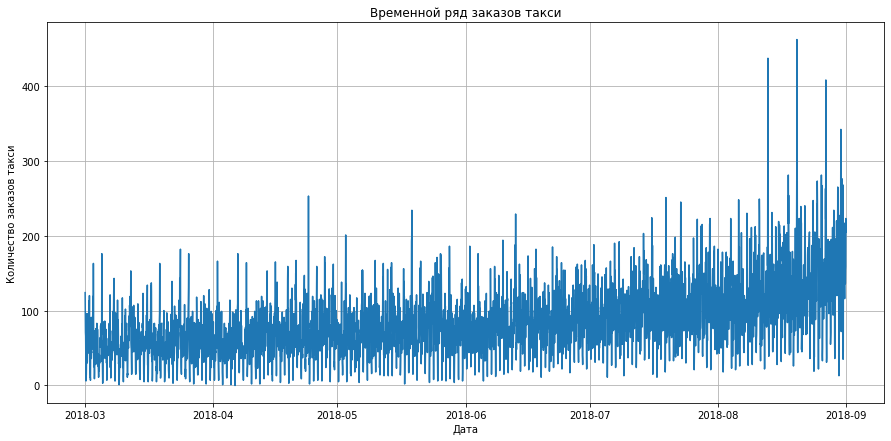

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(taxi_data_resampled.index, taxi_data_resampled.num_orders)
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.grid(True)
plt.show()

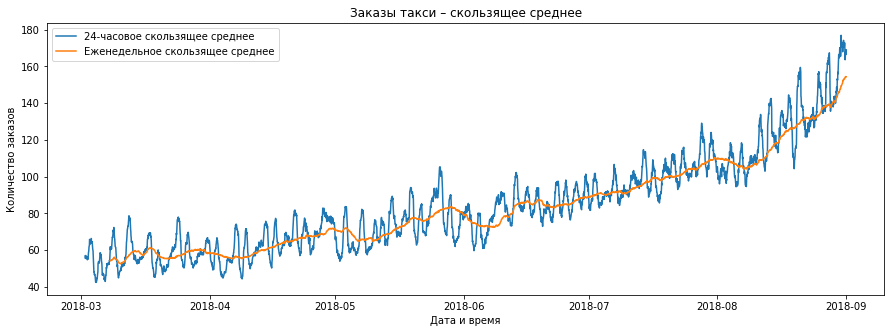

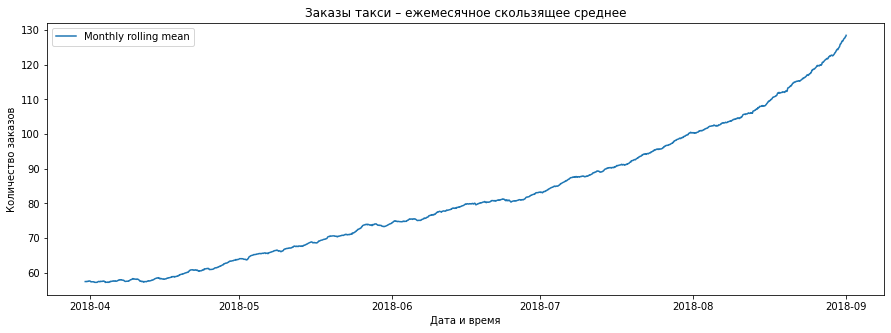

In [4]:
# Проверка ежедневных, еженедельных и ежемесячных закономерностей, если доступно достаточно данных
if len(taxi_data_resampled) > 24 * 7:
    plt.figure(figsize=(15, 5))
    plt.plot(taxi_data_resampled['num_orders'].rolling(window=24).mean(), label='24-часовое скользящее среднее')
    plt.plot(taxi_data_resampled['num_orders'].rolling(window=24*7).mean(), label='Еженедельное скользящее среднее')
    plt.title('Заказы такси – скользящее среднее')
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.legend()
    plt.show()

if len(taxi_data_resampled) > 24 * 30:
    plt.figure(figsize=(15, 5))
    plt.plot(taxi_data_resampled['num_orders'].rolling(window=24*30).mean(), label='Monthly rolling mean')
    plt.title('Заказы такси – ежемесячное скользящее среднее')
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.legend()
    plt.show()

На графике выше отображаются почасовые заказы такси за весь период. Кажется, существует некоторая тенденция и сезонность, а также периоды высокой изменчивости. 

Почасовые данные по заказам такси показывают колебания, которые могут соответствовать дневным или еженедельным циклам спроса. Чтобы лучше понять эти закономерности, я рассчитал скользящие средние значения за 24-часовой и 7-дневный периоды, что помогает сгладить данные и выявить основные тенденции.

Графики скользящего среднего показывают, что действительно существует некоторая изменчивость данных, которая может указывать на основные дневные и недельные закономерности. 24-часовое скользящее среднее показывает внутридневные тенденции, вероятно, отражая ежедневный цикл спроса, тогда как 7-дневное скользящее среднее предполагает недельный цикл. Кроме того, по месяцам наблюдается общая тенденция к росту или снижению, о чем свидетельствует месячное скользящее среднее.

***Чтобы лучше понять эти компоненты, мы можем разложить временной ряд на трендовые, сезонные и остаточные компоненты.***

После этого нам нужно будет разделить данные на наборы обучающих и тестовых данных, при этом набор тестовых данных будет содержать 10% исходных данных. Затем мы можем приступить к обучению различных моделей регрессии и оценке их с использованием метрики RMSE, стремясь к значению менее 48 в тестовой выборке.

In [5]:
taxi_data_resampled.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Ресемплированные почасовые данные содержат 4416 записей с количеством заказов в час от 0 до 462. Среднее количество заказов составляет примерно 84 со стандартным отклонением около 45, что указывает на некоторую изменчивость почасового объема заказов.

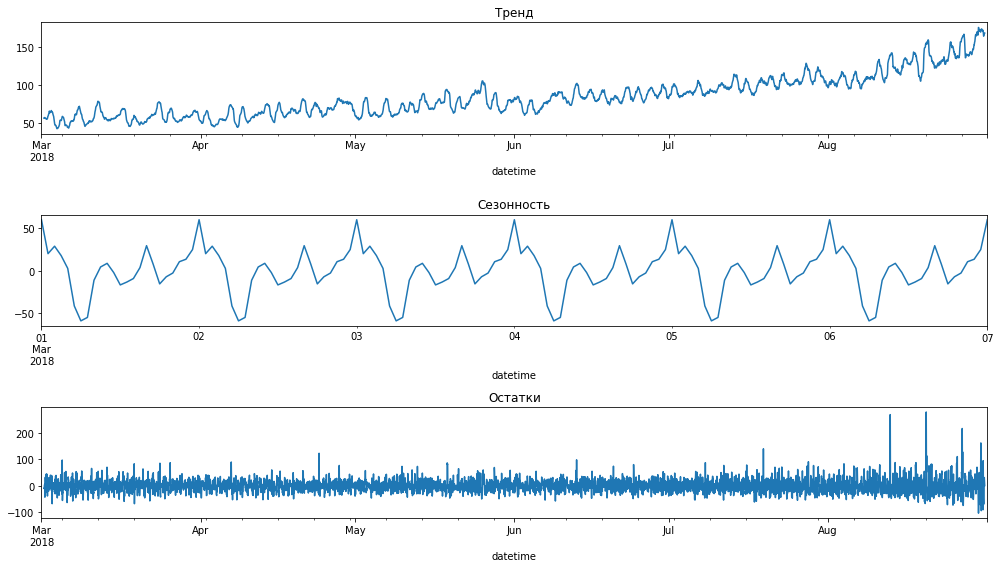

In [6]:
decomposed = seasonal_decompose(taxi_data_resampled)
plt.figure(figsize=(14, 8))

# Трендовый компонент
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.tight_layout()

# Сезонный компонент
plt.subplot(312)
# decomposed.seasonal.plot(ax=plt.gca())
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-07 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.tight_layout()

# Остаточная компонента
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

plt.show()

Декомпозиция временного ряда показывает следующее:

- Компонент тренда показывает, что с течением времени наблюдается общая тенденция к увеличению количества заказов такси.
- Компонент сезонности отображает регулярные колебания, которые соответствуют ***дневным циклам***.
- Остатки содержат шум в данных после учета тренда и сезонности.

Далее мы разделим данные на обучающий набор и тестовый набор. Мы зарезервируем 10% последних данных для тестирования. Затем мы сможем обучать различные модели и оптимизировать их гиперпараметры. Как только у нас будет подходящая модель, мы оценим ее производительность на тестовом наборе с использованием метрики RMSE. Перейдем к разделению данных.

## Обучение

In [7]:
# Функция для создания признаков запаздывания и скользящего среднего
def create_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

# Применим функцию проектирования признаков с задержкой в 168 часов (одна неделя).
max_lag = 168
rolling_mean_size = 24  # Скользящее окно одного дня

taxi_data_featured = create_features(taxi_data_resampled.copy(), max_lag, rolling_mean_size)

# Удаление первых строк «max_lag», содержащие значения NaN из-за запаздывающих признаков.
taxi_data_featured = taxi_data_featured.dropna()

# Отображение заголовка набора данных с новыми признаками
taxi_data_featured.head()

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [8]:
# Определение признаков и целевой переменных
features = taxi_data_featured.drop('num_orders', axis=1)
target = taxi_data_featured['num_orders']

# Разделение данных на 90% обучения и 10% тестирования.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

# Проверка полученных размеров
(features_train.shape, target_train.shape), (features_test.shape, target_test.shape)

(((3823, 169), (3823,)), ((425, 169), (425,)))

In [9]:
# Инициализация TimeSeriesSplit с 5 разбиениями
tscv = TimeSeriesSplit(n_splits=5)

# Проверка того, как TimeSeriesSplit делит данные
for train_index, test_index in tscv.split(features_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("Train set size:", len(train_index), "Test set size:", len(test_index))

# Этот вывод предназначен только для того, чтобы показать, как выполняется разделение, 
# фактическая перекрестная проверка будет использоваться в GridSearchCV.

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

TimeSeriesSplit разделил обучающие данные на 5 частей для перекрестной проверки, гарантируя, что набор проверки всегда будет следовать по времени после обучающего набора. Этот метод предотвращает проверку модели на прошлых данных, что имеет решающее значение для прогнозирования временных рядов.

Теперь мы перейдем к настройке гиперпараметров для моделей LinearRegressor и RandomForestRegressor. Мы будем использовать GridSearchCV с нашей схемой перекрестной проверки TimeSeriesSplit.

Поскольку настройка гиперпараметров, особенно для случайных лесов, может потребовать больших вычислительных ресурсов, нам необходимо определить разумную сетку параметров для исследования. Мы начнем с более ограниченной сетки, чтобы можно было контролировать время вычислений.

In [10]:
# Определим модели
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=123)

# Определим сетку параметров для RandomForestRegressor
# Примечание: Мы используем упрощенную сетку, чтобы сократить время вычислений.
param_grid_rf = {
    'n_estimators': [10],
    'max_depth': [5],
    'min_samples_split': [10],
    'min_samples_leaf': [5]
}

# Определим scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Настройка GridSearchCV для RandomForestRegressor с помощью TimeSeriesSplit
gsearch_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring=scorer,
    cv=tscv,
    n_jobs=-1  # Используем все доступные ядра
)

# Подберем GridSearchCV, чтобы найти лучшие параметры для RandomForestRegressor.
gsearch_rf.fit(features_train, target_train)

# Получим лучшие параметры и соответствующую оценку для RandomForestRegressor
best_params_rf = gsearch_rf.best_params_
best_score_rf = np.sqrt(-gsearch_rf.best_score_)

best_params_rf, best_score_rf

({'max_depth': 5,
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 10},
 24.16710915791019)

In [11]:
# Поскольку LinearReгрессия на самом деле не имеет гиперпараметров для настройки, мы напрямую используем cross_val_score.
scores_lr = cross_val_score(
    estimator=model_lr,
    X=features_train,
    y=target_train,
    cv=tscv,
    scoring=scorer,
    n_jobs=-1
)

# Вычислим RMSE для линейной регрессии
rmse_scores_lr = np.sqrt(-scores_lr)
mean_rmse_lr = np.mean(rmse_scores_lr)
mean_rmse_lr

22.706636911475737

## Тестирование

In [12]:
# Обучим модель линейной регрессии на всем обучающем наборе
model_lr.fit(features_train, target_train)

# Прогнозирование на тестовом наборе
predictions_test_lr = model_lr.predict(features_test)

# Вычислим RMSE для прогнозов тестового набора
rmse_test_lr = mean_squared_error(target_test, predictions_test_lr, squared=False)
rmse_test_lr

34.308158875166626

***Модель линейной регрессии*** достигла ***RMSE примерно 34 на тестовом наборе***, что *ниже порога в 48*, установленного для цели проекта. Это означает, что модель линейной регрессии ***соответствует требованиям проекта к тестовой выборке***.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48